In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

select u from random distribution 0~1

In [2]:
from scipy.stats import truncnorm
# normal distribution 0~1
lower, upper = 0, 1
mu, sigma = 0.5, 0.2
distribution = truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

functions

In [3]:
def obj_func(b_Beta, multiplier, u, n):
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i
    m1 = multiplier[0]
    m2 = multiplier[1:n+1]
    m3 = multiplier[n+1]
    m4 = multiplier[n+2]
    m5 = multiplier[n+3:2*n+3]
    
    obj = np.sum(p * np.log((p/Beta).astype(np.float64))) - np.sum(b * np.log(u)) \
        + np.sum(m1 * (p - q)) + np.sum(m2 * (Beta.reshape((n,1)) - p/u)) \
        + np.sum(m3 * (1 - p)) + np.sum(m4 * (1 - q)) \
        + np.sum(m5 * (0 - b)) 

    return obj

def update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, t, learning_rate, n):
    
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i
    m1 = multiplier[0]
    m2 = multiplier[1:n+1]
    m3 = multiplier[n+1]
    m4 = multiplier[n+2]
    m5 = multiplier[n+3:2*n+3]

    grad_b_term1 = np.array([[np.log(p[j]/Beta[j])+1 for j in range(n)] for i in range(n)] )
    grad_b_term2 = -np.log(u)
    grad_b_m1_term = np.array([[0.0]*n for i in range(n)])
    for i in range(n):
        for j in range(n):
            if i==j:
                grad_b_m1_term[i][j] = 0.0
            else:
                grad_b_m1_term[i][j] = m1[j]-m1[i]
    grad_b_m2_term = np.array([[np.sum([-m2[i][j]/u[i][j] for i in range(n)]) for j in range(n)] for row in range(n)])
    grad_b_m3_term = np.array([[-m3[j] for j in range(n)] for i in range(n)])
    grad_b_m4_term = np.array([[-m4[j] for j in range(n)] for i in range(n)]).T
    grad_b_m5_term = -m5 
    grad_Beta_term1 = np.array([[-p[j]/Beta[j] for j in range(n)]])
    grad_Beta_m2_term = np.array([[np.sum(m2,axis=1)[j] for j in range(n)]]) 

    grad_b = grad_b_term1 + grad_b_term2 + grad_b_m1_term + grad_b_m2_term + grad_b_m3_term + grad_b_m4_term + grad_b_m5_term
    grad_Beta = grad_Beta_term1 + grad_Beta_m2_term
    grad_b_Beta = np.concatenate((grad_b, grad_Beta), axis=0)

    learning_rate = learning_rate
    # OGD
    b_Beta = b_Beta - 2 * learning_rate * grad_b_Beta + learning_rate * grad_b_Beta_history[t-1]

    grad_b_Beta_history.append(grad_b_Beta)

    return b_Beta
    

def calculate_p_q(b):
    q = np.sum(b, axis=1)
    p = np.sum(b, axis=0)

    return p, q

def update_multiplier(multiplier, b_Beta, u, grad_multiplier_history, t, learning_rate, n):
    
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i

    grad_m1 = (p - q).reshape((1,n))
    grad_m2 = Beta.reshape((n,1)) - p/u
    grad_m3 = (1 - p).reshape((1,n))
    grad_m4 = (1 - q).reshape((1,n))
    grad_m5 = 0 - b 
    grad_m1_m2_m3_m4_m5 = np.concatenate((grad_m1, grad_m2, grad_m3, grad_m4, grad_m5), axis=0)
    
    learning_rate = learning_rate
    # OGA
    multiplier = multiplier + 2 * learning_rate * grad_m1_m2_m3_m4_m5 - learning_rate * grad_multiplier_history[t-1]

    grad_multiplier_history.append(grad_m1_m2_m3_m4_m5)

    multiplier[1:2*n+3] = np.where(multiplier[1:2*n+3]<0, 0, multiplier[1:2*n+3])

    return multiplier

main function

In [4]:
def start_experiment(T, learning_rate, u, n):
    '''
    Parameters
    ----------
        T: iterations
        learning_rate: stepsize
        u: (int)random_state, (ndarray)input array
        n: number of agents
    
    Return
    ------
        result: experiment results
    '''

    if type(u)==int:
        random_state = u
        u = distribution.rvs((n,n),random_state=random_state)
    elif type(u)==np.ndarray:
        random_state = 'given'
        u = u
    else:
        print('Not a valid input u')
        
    for t in range(T):
        if t==0:
            b = np.full((n,n),1/n)            

            q = np.sum(b, axis=1)
            p = np.sum(b, axis=0)
            q_history = [q]
            p_history = [p]

            Beta=np.full(n,1.0)
            
            b_Beta = np.concatenate((b, Beta.reshape((1,n))), axis=0)
            b_Beta_history = [b_Beta]

            multiplier = np.zeros((2*n+3,n))
            multiplier_history = [multiplier]

            obj = obj_func(b_Beta, multiplier, u, n)
            obj_history = [obj]
            avg_obj_history = [obj]
            
            max_obj_when_x_history = [obj]
            min_obj_when_y_history = []

            grad_b_Beta_history = [np.zeros((n+1,n))]
            grad_multiplier_history = [np.zeros((2*n+3,n))]

        else:
            b_Beta = update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, t, learning_rate, n)
            b_Beta_history.append(b_Beta)
            
            b = b_Beta[:n]
            p, q = calculate_p_q(b)
            q_history.append(q)
            p_history.append(p)
            
            min_obj_when_y = obj_func(b_Beta, multiplier, u, n)
            min_obj_when_y_history.append(min_obj_when_y)
            
            multiplier = update_multiplier(multiplier, b_Beta, u, grad_multiplier_history, t, learning_rate, n)
            multiplier_history.append(multiplier)

            obj = obj_func(b_Beta, multiplier, u, n)
            obj_history.append(obj)

            max_obj_when_x_history.append(obj)

            avg_obj_history.append((avg_obj_history[-1] * len(avg_obj_history) + obj)/(len(avg_obj_history)+1))

    b_Beta = update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, t, learning_rate, n)
    b_Beta_history.append(b_Beta)
    
    b = b_Beta[:n]
    p, q = calculate_p_q(b)
    q_history.append(q)
    p_history.append(p)
    
    min_obj_when_y = obj_func(b_Beta, multiplier, u, n)
    min_obj_when_y_history.append(min_obj_when_y)

    result = {
        'T': T,
        'lr': learning_rate,
        'n': n,
        'u': u,
        'random_state': random_state,
        'objective': obj_history[-1],
        'min_obj': np.min(obj_history),
        'obj_history': obj_history,
        'avg_obj_history': avg_obj_history,
        'b_Beta_history': b_Beta_history,
        'q_history': q_history,
        'p_history': p_history,
        'multiplier_history': multiplier_history,
        'grad_b_Beta_history': grad_b_Beta_history,
        'grad_multiplier_history': grad_multiplier_history,
        'max_obj_when_x_history': max_obj_when_x_history,
        'min_obj_when_y_history': min_obj_when_y_history
    }
    # save to pickle for reuse
    with open('experiment/Minimax_OGDA/n_{}_u_{}_lr{}_iter{}.pickle'.format(n,random_state,learning_rate,T), 'wb') as f:
        pickle.dump(result, f)

    return result

draw plt functions

In [5]:
def draw_obj_plt(result, ylim):
    # plot obj curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    t = range(T)
    plt.plot(t, result['obj_history'], label='obj', c='b')
    plt.plot(t, result['avg_obj_history'], label='average_obj', c='r')
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    # plt.scatter(t[-1], result['objective'], c='y', label='obj={}'.format(result['objective']))
    # plt.scatter(np.argmin(result['obj_history']), np.min(result['obj_history']), c='g', label='min={}\n t={}'.format(np.min(result['obj_history']), np.argmin(result['obj_history'])))
    plt.title('Minimax_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.xlabel('t')
    plt.ylabel('obj')
    
    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Minimax_OGDA/obj/Minimax_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))
    # plt.close()

def draw_duality_gap_plt(result, ylim):
    # plot duality gap curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    duality_gap_history = np.subtract(result['max_obj_when_x_history'], result['min_obj_when_y_history'] )

    t = range(T)
    plt.plot(t, duality_gap_history, label='duality gap', c='b')
    plt.title('Minimax_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('duality gap')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Minimax_OGDA/dual/Minimax_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_distance_plt(result, best, ylim):
    # plot distance between z and z* curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    # approximate z* by running OGDA for much more iterations and taking the very last iterate
    x_star = best['b_Beta_history'][-1]
    y_star = best['multiplier_history'][-1]
    x = result['b_Beta_history']
    y = result['multiplier_history']

    distance_history = []
    for t in range(T):
        x = result['b_Beta_history'][t]
        y = result['multiplier_history'][t]
        distance = np.sqrt( np.sum(np.square(x - x_star)) + np.sum(np.square(y - y_star)))
        distance_history.append(distance)
    
    t = range(T)
    plt.plot(t, distance_history, label='distance', c='b')
    plt.title('Minimax_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('distance between z & z*')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Minimax_OGDA/distance/Minimax_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_two_obj_plt(result1, result2, ylim):
    # plot obj curve
    T = result1['T']
    learning_rate = result1['lr']
    random_state = result1['random_state']
    n = result1['n']

    t = range(T)
    plt.plot(t, result1['obj_history'], label='GDA obj', c='b')
    # plt.plot(t, result1['avg_obj_history'], label='GDA average_obj', c='c')
    plt.plot(t, result2['obj_history'], label='OGDA obj', c='orange')
    # plt.plot(t, result2['avg_obj_history'], label='OGDA average_obj', c='m')
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    # plt.scatter(t[-1], result['objective'], c='y', label='obj={}'.format(result['objective']))
    # plt.scatter(np.argmin(result['obj_history']), np.min(result['obj_history']), c='g', label='min={}\n t={}'.format(np.min(result['obj_history']), np.argmin(result['obj_history'])))
    plt.title('Group2_GDA_vs_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.xlabel('t')
    plt.ylabel('obj')
    
    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Group2_GDA_vs_OGDA/obj/GDA_vs_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_two_duality_gap_plt(result1, result2, ylim):
    # plot duality gap curve
    T = result1['T']
    learning_rate = result1['lr']
    random_state = result1['random_state']
    n = result1['n']

    duality_gap_history1 = np.subtract(result1['max_obj_when_x_history'], result1['min_obj_when_y_history'] )
    duality_gap_history2 = np.subtract(result2['max_obj_when_x_history'], result2['min_obj_when_y_history'] )

    t = range(T)
    plt.plot(t, duality_gap_history1, label='GDA duality gap', c='b')
    plt.plot(t, duality_gap_history2, label='OGDA duality gap', c='orange')
    plt.title('Group2_GDA_vs_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('duality gap')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Group2_GDA_vs_OGDA/dual/GDA_vs_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_two_distance_plt(result1, result2, best1, best2, ylim):
    # plot distance between z and z* curve
    T = result1['T']
    learning_rate = result1['lr']
    random_state = result1['random_state']
    n = result1['n']

    # approximate z* by running OGDA for much more iterations and taking the very last iterate
    GDAbest = best1
    x_star = GDAbest['b_Beta_history'][-1]
    y_star = GDAbest['multiplier_history'][-1]
    x = result1['b_Beta_history']
    y = result1['multiplier_history']

    distance_history1 = []
    for t in range(T):
        x = result1['b_Beta_history'][t]
        y = result1['multiplier_history'][t]
        distance = np.sqrt( np.sum(np.square(x - x_star)) + np.sum(np.square(y - y_star)))
        distance_history1.append(distance)

    OGDAbest = best2
    x_star = OGDAbest['b_Beta_history'][-1]
    y_star = OGDAbest['multiplier_history'][-1]
    x = result2['b_Beta_history']
    y = result2['multiplier_history']

    distance_history2 = []
    for t in range(T):
        x = result2['b_Beta_history'][t]
        y = result2['multiplier_history'][t]
        distance = np.sqrt( np.sum(np.square(x - x_star)) + np.sum(np.square(y - y_star)))
        distance_history2.append(distance)
    
    t = range(T)
    plt.plot(t, distance_history1, label='GDA distance', c='b')
    plt.plot(t, distance_history2, label='OGDA distance', c='orange')
    plt.title('Group2_GDA_vs_OGDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('z z* distance')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')
        
    plt.legend()
    plt.savefig('experiment/Group2_GDA_vs_OGDA/distance/GDA_vs_OGDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

In [6]:
def summary(result):
    n = result['n']
    u = result['u']
    random_state = result['random_state']
    b = result['b_Beta_history'][-1][:n]
    Beta = result['b_Beta_history'][-1][n]
    p = result['p_history'][-1]
    q = result['q_history'][-1]
    m1 = result['multiplier_history'][-1][0]
    m2 = result['multiplier_history'][-1][1:n+1]
    m3 = result['multiplier_history'][-1][n+1]
    m4 = result['multiplier_history'][-1][n+2]
    m5 = result['multiplier_history'][-1][n+3:2*n+3]
    obj = result['objective']

    term1 = np.sum(p * np.log((p/Beta).astype(np.float64))) 
    term2 = np.sum(b * np.log(u)) 
    m1_term = np.sum(m1 * (p - q)) 
    m2_term = np.sum(m2 * (Beta.reshape((n,1)) - p/u)) 
    m3_term = np.sum(m3 * (1 - p)) 
    m4_term = np.sum(m4 * (1 - q)) 
    m5_term = np.sum(m5 * (0 - b)) 
    print('n',n)
    print('u',u)
    print('random_state',random_state)
    print('---------------------------------------') 
    print('term1',term1)
    print('term2',term2)
    print('m1_term',m1_term)
    print('m2_term',m2_term)
    print('m3_term',m3_term)
    print('m4_term',m4_term)
    print('m5_term',m5_term)
    print('---------------------------------------') 
    print('obj',obj)                  
    print('b',b)
    print('Beta',Beta)
    print('q',q)
    print('p',p)
    print('m1',m1)
    print('m2',m2)
    print('m3',m3)
    print('m4',m4)
    print('m5',m5)

start experiments

In [7]:
result = start_experiment(1000000, 0.001, 1, 3)

In [8]:
summary(result)

n 3
u [[0.45862438 0.61513834 0.00127856]
 [0.39786394 0.29369125 0.24069981]
 [0.32453616 0.42157274 0.44832023]]
random_state 1
---------------------------------------
term1 -3.2485191774412723
term2 -2.8994053927990824
m1_term 0.0004711292820846406
m2_term -0.00016184488074186894
m3_term 0.0
m4_term 0.0
m5_term 0.353470467369696
---------------------------------------
obj 0.004674894578507116
b [[ 0.05470342  1.49102677 -0.0590198 ]
 [ 1.4808095  -0.05910325  0.06164463]
 [-0.05066626  0.05255952  1.44208612]]
Beta [2.41252438 3.73191383 3.22325076]
q [1.48671039 1.48335088 1.44397938]
p [1.48484666 1.48448303 1.44471095]
m1 [-0.14172302  0.25791688 -0.11619386]
m2 [[0.         0.61569966 0.        ]
 [0.39675078 0.         0.        ]
 [0.         0.         0.44877678]]
m3 [0. 0. 0.]
m4 [0. 0. 0.]
m5 [[0.28579284 0.         5.86927063]
 [0.         0.31695844 0.26002315]
 [0.66801584 0.26349071 0.        ]]


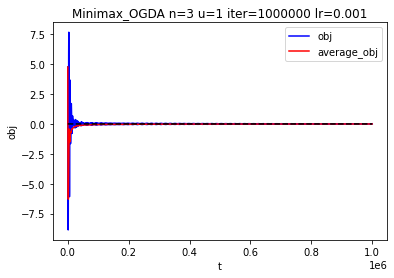

In [9]:
draw_obj_plt(result, None)

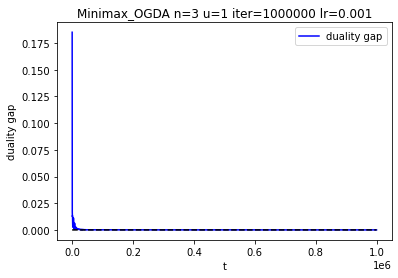

In [10]:
draw_duality_gap_plt(result, None)

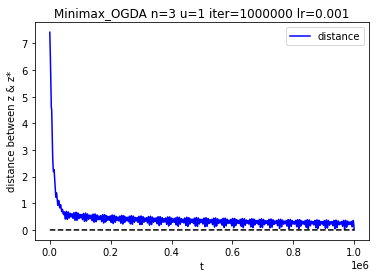

In [11]:
draw_distance_plt(result, result, None)

In [12]:
with open('experiment/Minimax_GDA/n_3_u_1_lr0.001_iter1000000.pickle', 'rb') as f:
    GDA = pickle.load(f)
with open('experiment/Minimax_OGDA/n_3_u_1_lr0.001_iter1000000.pickle', 'rb') as f:
    OGDA = pickle.load(f)

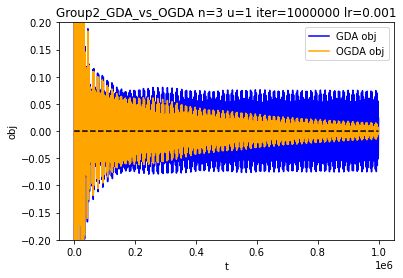

In [13]:
draw_two_obj_plt(GDA, OGDA, (-0.2, 0.2))

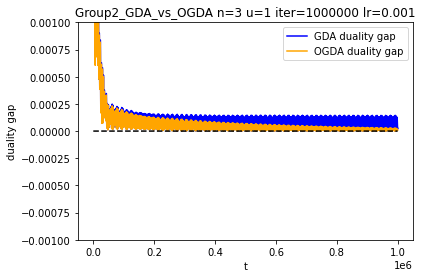

In [14]:
draw_two_duality_gap_plt(GDA, OGDA, (-0.001, 0.001))

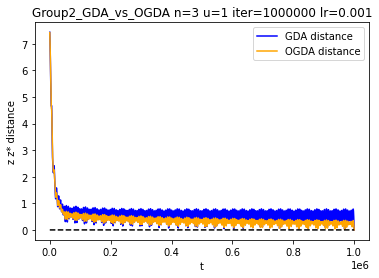

In [15]:
draw_two_distance_plt(GDA, OGDA, GDA, OGDA, None)